In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [234]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


num_steps = 10
#betas = torch.tensor([1.7e-5] * num_steps)
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
alphas_bar_sqrt[-1] = 0
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
one_minus_alphas_bar_sqrt[-1] = 1


def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)


def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [235]:
BATCH_SIZE = 1024


class QX:
    def __init__(self, time_step=None):
        self.ts = time_step

    def __call__(self, sample):
        return q_x(sample, torch.tensor(self.ts))


transform = transforms.Compose([
    transforms.ToTensor(),
    QX(range(10))
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

(array([20.2704526 ,  0.0621793 ,  0.21762758,  0.06217929,  0.12435864,
         0.0621793 ,  0.09326895,  0.12435864,  0.12435855,  0.06217932,
         0.09326891,  0.03108966,  0.        ,  0.18653796,  0.1554483 ,
         0.1554483 ,  0.06217932,  0.09326884,  0.03108966,  0.09326898,
         0.1554483 ,  0.27980694,  0.03108961,  0.40416558,  1.39903469]),
 array([-0.01341682,  0.02761002,  0.06863686,  0.1096637 ,  0.15069056,
         0.19171739,  0.23274423,  0.27377108,  0.31479791,  0.35582477,
         0.3968516 ,  0.43787846,  0.47890529,  0.51993215,  0.56095898,
         0.60198581,  0.64301264,  0.68403947,  0.72506636,  0.76609319,
         0.80712003,  0.84814686,  0.88917369,  0.93020058,  0.97122741,
         1.01225424]),
 <BarContainer object of 25 artists>)

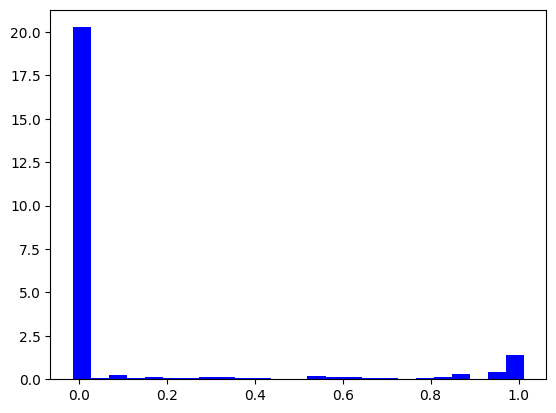

In [236]:
img0 = next(iter(train_loader))[0][0]
plt.hist(img0[0].flatten(), bins=25, density=True, color='b')

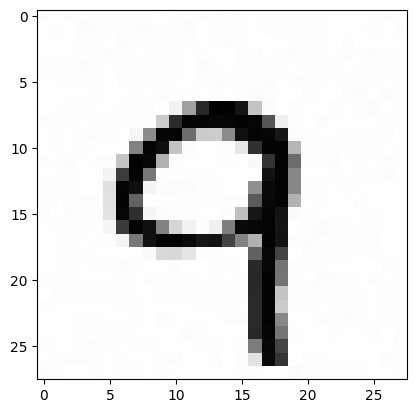

In [237]:
plt.imshow(img0[0], cmap='Greys')

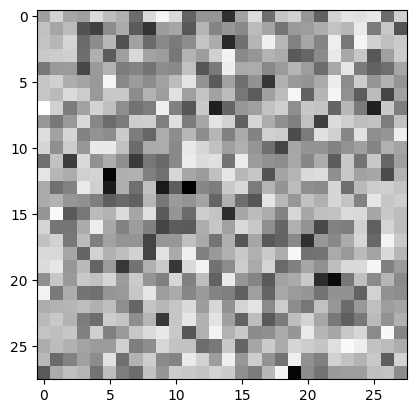

In [238]:
plt.imshow(img0[-1], cmap='Greys')

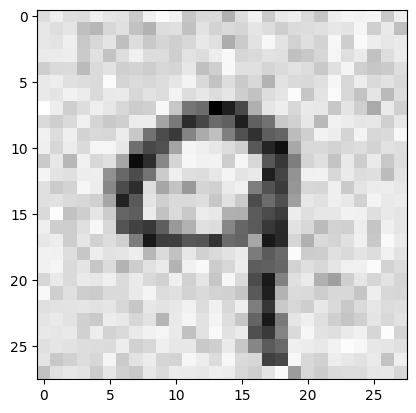

In [239]:
plt.imshow(img0[-2], cmap='Greys')

In [240]:
class TimestepLike(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size * 2)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.hiddenSize = hidden_size

    def forward(self, X):
        h0 = self.encoder(X)
        h1, h2 = torch.chunk(h0, 2, dim=-1)
        h = torch.mul(h1, torch.softmax(h2, dim=-1))
        return self.decoder(nn.functional.leaky_relu(h))


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.h = TimestepLike(28 * 28, 256)
        self.mu = TimestepLike(256, 28 * 28)
        self.var = TimestepLike(256, 28 * 28)
        self.decoder = nn.Sequential(nn.Linear(28 * 28, 256),
                                     nn.LeakyReLU(),
                                     nn.Linear(256, 28 * 28))

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, X):
        h = self.h(X)
        mu = self.mu(h)
        var = self.var(h)
        return self.decoder(self.reparameterize(mu, var))

In [241]:
model = nn.Linear(28 * 28, 28 * 28).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=20, verbose=False, threshold=1e-3)

In [249]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            X = data[:,-1].to('cuda').view(-1, 28 * 28)
            Y = data[:,-2].to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output = model(X)
            loss = L2Loss(output,Y)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tLoss: {:.8f}\t lr: {:.8f}'.format(
                epoch, loss.item(), optimizer.param_groups[0]['lr']))
    return allLoss

In [250]:
for epoch in range(1, 1001):
    loss = train(model,train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 10%|█         | 6/59 [00:01<00:08,  5.90batch/s,  Epoch: 48 	Loss: 0.06673016	 lr: 0.00010000]


KeyboardInterrupt: 

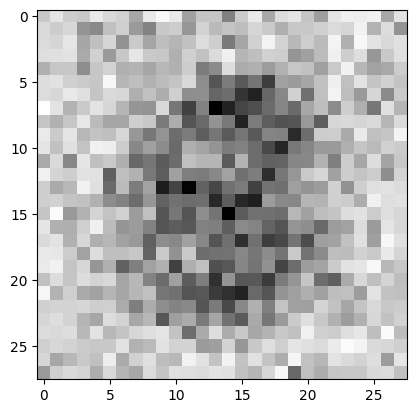

In [251]:
y = model(img0[-1].to('cuda', torch.float32).view(-1, 28 * 28))
plt.imshow(y.cpu().detach().view(28, 28), cmap='Greys')

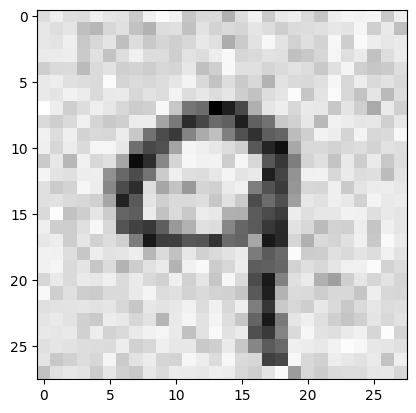

In [252]:
plt.imshow(img0[-2].view(28, 28), cmap='Greys')